# Map Matching

Wannes Meert, KU Leuven, 2017

## Load libraries

In [6]:
import os, sys, importlib, math
import matplotlib.pyplot as plt
import numpy as np
import tqdm
%matplotlib inline

In [7]:
sys.path.append(os.path.join(os.getcwd(), os.pardir))

We will load the DTAI MapMatching library. It is based on an HMM-like model and Viterbi decoding. If you want to know more details about this algorithm. Check the `docs` directory.

In [8]:
import dtaimapmatching as mm
from dtaimapmatching import visualization as mm_visualization

## Example 1

### Create the map and path

We create a map that looks like a lattice within the bounds [0,6] for the x-axis and [1,3] for the y-axis. Next we also define a path of an object that traverses the graph over nodes A, B, D, E, and F. To experiment with the algorithm you can optionally add an outlier that represents a noise observation.

In [11]:
add_outlier = True

map_con = mm.map.InMemMap(graph=[
    ("A", (1, 1), ["B", "C", "X"]),
    ("B", (1, 3), ["A", "C", "D", "K"]),
    ("C", (2, 2), ["A", "B", "D", "E", "X", "Y"]),
    ("D", (2, 4), ["B", "C", "D", "E", "K", "L"]),
    ("E", (3, 3), ["C", "D", "F", "Y"]),
    ("F", (3, 5), ["D", "E", "L"]),
    ("X", (2, 0), ["A", "C", "Y"]),
    ("Y", (3, 1), ["X", "C", "E"]),
    ("K", (1, 5), ["B", "D", "L"]),
    ("L", (2, 6), ["K", "D", "F"])
], use_latlon=False)

path = [(0.8, 0.7), (0.9, 0.7), (1.1, 1.0), (1.2, 1.5), (1.2, 1.6), (1.1, 2.0),
        (1.1, 2.3), (1.3, 2.9), (1.2, 3.1), (1.5, 3.2), (1.8, 3.5), (2.0, 3.7),
        (2.3, 3.5), (2.4, 3.2), (2.6, 3.1), (2.9, 3.1), (3.0, 3.2),
        (3.1, 3.8), (3.0, 4.0), (3.1, 4.3), (3.1, 4.6), (3.0, 4.9)]

if add_outlier:
    path.insert(13, (2.3, 1.8))

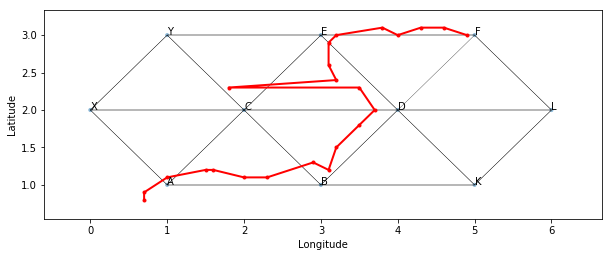

In [12]:
mm_visualization.plot_map(map_con, path=path, show_labels=True)

### Apply Map Matching

In [15]:
importlib.reload(mm.matching)
matcher = mm.matching.Matcher(map_con, max_dist=2, obs_noise=1, min_prob_norm=0.5,
                              movement_props=mm.matching.MovementProps)
nodes = matcher.match(path, unique=False, tqdm=tqdm.tqdm_notebook)
print("Result\n------")
print(nodes)
print("")
matcher.print_lattice_stats()


Result
------
['A', ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), ('A', 'B'), 'B', ('B', 'D'), ('B', 'D'), ('B', 'D'), 'D', ('D', 'E'), ('D', 'E'), ('D', 'E'), ('D', 'E'), 'E', ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F'), ('E', 'F')]

Stats lattice
-------------
nbr levels               : 23
nbr lattice              : 162
avg lattice[level]       : 7.043478260869565
min lattice[level]       : 1
max lattice[level]       : 14
avg obs distance         : 0.21543683759394955
last logprob             : -14.467352829115361
last norm logprob        : -0.6028063678798067


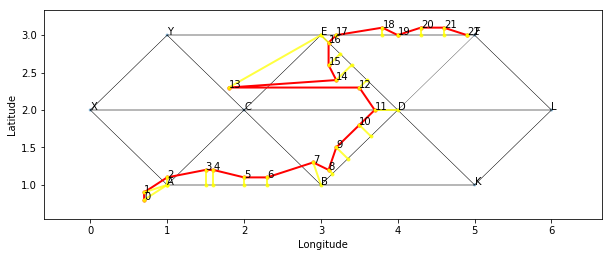

In [21]:
importlib.reload(mm.visualization)
mm_visualization.plot_map(map_con, path=path, nodes=nodes, counts=matcher.node_counts(),
                         show_labels=True)

### Smooth the Path

Another strategy to reduce noise in the path is to apply a Kalman filter to correct the measurements. Optionally, the method can remove outliers by removing the most deviating points before re-estimating.

In [22]:
kf = None

/Users/wannes/Projects/Research/2016-MapMatching/repo_mapmatching/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


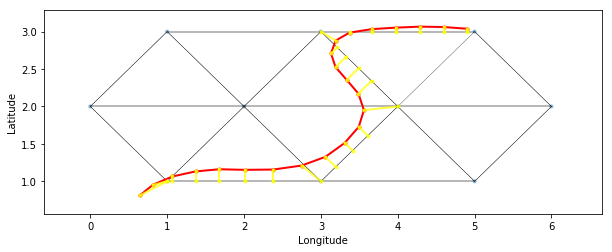

In [23]:
importlib.reload(mm)
importlib.reload(mm.util)

path_means, path_vars, kf = mm.util.smooth_path(path, obs_noise=0.4,
                                                loc_var=0.5, vel_var=0.5,
                                                kf=kf, rm_outliers=2,
                                                n_iter=100)
path_smoothed = path_means[:,:2]
matcher = mm.matching.Matcher(map_con, max_dist=2, obs_noise=1, min_prob_norm=0.5)
nodes = matcher.match(path_smoothed, unique=False, tqdm=tqdm.tqdm_notebook)
mm_visualization.plot_map(map_con, path=list(path_smoothed), nodes=nodes)

## Example 2

For the second example we focus on a set of observations where the distance between two observations is larger than the distance between nodes in the graph.

### Create the map and path

In [25]:
map_con = mm.map.InMemMap(graph=[
    ("A", (1, 1), ["B", "C", "X"]),
    ("B", (1, 3), ["A", "C", "D", "K"]),
    ("C", (2, 2), ["A", "B", "D", "E", "X", "Y"]),
    ("D", (2, 4), ["B", "C", "E", "K", "L", "F"]),
    ("E", (3, 3), ["C", "D", "F", 
                   "Y"]),
    ("F", (3, 5), ["D", "E", "L"]),
    ("X", (2, 0), ["A", "C", "Y"]),
    ("Y", (3, 1), ["X", "C", "E"]),
    ("K", (1, 5), ["B", "D", "L"]),
    ("L", (2, 6), ["K", "D", "F"])
], use_latlon=False)

path = [(1.8, 0.1), (1.8, 3.5), (3.0, 4.9)]

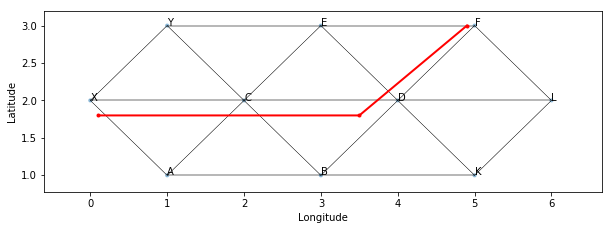

In [26]:
mm_visualization.plot_map(map_con, path=path, show_labels=True)

### Apply map matching

In [27]:
importlib.reload(mm.matching)
matcher = mm.matching.Matcher(map_con, max_dist=2, obs_noise=1,
                              min_prob_norm=0.5, non_emitting_states=True)
try:
    nodes = matcher.match(path, unique=False, tqdm=tqdm.tqdm_notebook)
    print("Result\n------")
    print(nodes)
    print("")
except Exception as exc:
    print('Error:', exc)
    nodes= None
matcher.print_lattice_stats()


Result
------
['X', 'C', 'D', ('D', 'F')]

Stats lattice
-------------
nbr levels               : 3
nbr lattice              : 50
avg lattice[level]       : 16.666666666666668
min lattice[level]       : 14
max lattice[level]       : 20
avg obs distance         : 0.25820848914552097
last logprob             : -1.0956654105789096
last norm logprob        : -0.21913308211578192


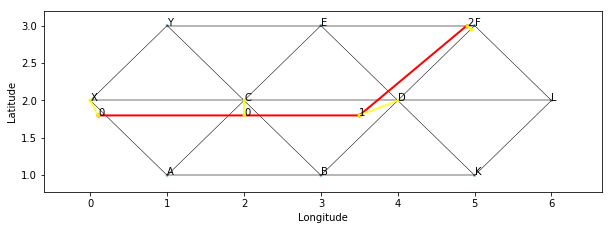

In [28]:
mm_visualization.plot_map(map_con, path=path, matcher=matcher, show_labels=True)

## Illustrate observation noise distribition

The method above is based on the assumption that measurements can be noisy. We assume that Gaussian noise is added to the observation according to the given standard deviation:

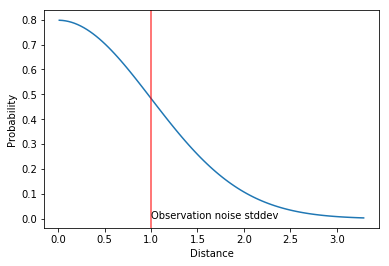

In [24]:
mm_visualization.plot_obs_noise_dist(mm.matching.Matcher(map, obs_noise=1))